In [80]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk

In [81]:
#getting the data from url
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

In [82]:
reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [83]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Excellent service both on th...
1,✅ Trip Verified | Good lounge at Cape Town. O...
2,✅ Trip Verified | A really excellent journey....
3,✅ Trip Verified | This flight was one of the ...
4,Not Verified | It seems that there is a race t...


In [84]:
df.to_csv("BA_reviews.csv")

->This the reviews dataset that was collect from the web https://www.airlinequality.com/airline-reviews/british-airways by webscraping using BeautifulSoup package in python.

-> here the text is in raw form,which contains many characters which does not add any information to the model building.

->So,we need to preprocess the data

In [85]:
#step 1: we have to split the above dataset into two columns
df[['Verified status','Review']] = df.reviews.str.split('|',expand = True)

In [86]:
df.head()

,reviews,Verified status,Review
0,✅ Trip Verified | Excellent service both on th...,✅ Trip Verified,Excellent service both on the ground and on b...
1,✅ Trip Verified | Good lounge at Cape Town. O...,✅ Trip Verified,Good lounge at Cape Town. On time departure....
2,✅ Trip Verified | A really excellent journey....,✅ Trip Verified,A really excellent journey. Lounge not overc...
3,✅ Trip Verified | This flight was one of the ...,✅ Trip Verified,This flight was one of the worst I have ever...
4,Not Verified | It seems that there is a race t...,Not Verified,It seems that there is a race to the bottom a...


In [87]:
#we have two splitted  columns, so we can drop the previous reviews column which is not useful 
df = df.drop(columns = ['reviews'])

In [88]:
df.head()

,Verified status,Review
0,✅ Trip Verified,Excellent service both on the ground and on b...
1,✅ Trip Verified,Good lounge at Cape Town. On time departure....
2,✅ Trip Verified,A really excellent journey. Lounge not overc...
3,✅ Trip Verified,This flight was one of the worst I have ever...
4,Not Verified,It seems that there is a race to the bottom a...


In [89]:
#we have to clean the data ✅,spaces should be eliminated which is not a text data
df['Verified status']=df['Verified status'].str.replace(r'✅','')
df['Verified status']=df['Verified status'].str.strip()#to remove spaces

In [90]:
import nltk
import re
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
lemma=WordNetLemmatizer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vamsi2001\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [91]:
clean_review=[]
for i in range(len(df['Review'])):
    review=re.sub('[^a-zA-Z]',' ',df['Review'][i])#cleaning urls
    review=review.lower()#lowering the text
    review=review.split()#
    review=[lemma.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review=' '.join(review)
    clean_review.append(review)

In [92]:
clean_review[0]

'excellent service ground board first class product might leading edge service around entire experience well worth cost ticket concorde room heathrow well managed great place relax prior trip flight slightly delayed heathrow arrived schedule johannesburg'

In [94]:
df['Review']=clean_review

In [95]:
df.head()

,Verified status,Review
0,Trip Verified,excellent service ground board first class pro...
1,Trip Verified,good lounge cape town time departure drink hig...
2,Trip Verified,really excellent journey lounge overcrowded la...
3,Trip Verified,flight one worst ever life wanted pamper bough...
4,Not Verified,seems race bottom amongst airline cannot even ...


-> As the dataset does not contain any labels related to the sentiment of the data we can analyse the sentiment of the review by using textblob

In [96]:
from textblob import TextBlob

In [97]:
sent_score=[]
for i in range(len(df['Review'])):
    textblob=TextBlob(df['Review'][i])
    x=textblob.sentiment.polarity
    sent_score.append(x)   

In [98]:
df['Polarity']=sent_score

In [99]:
data=df
data.head()

,Verified status,Review,Polarity
0,Trip Verified,excellent service ground board first class pro...,0.311905
1,Trip Verified,good lounge cape town time departure drink hig...,0.260000
2,Trip Verified,really excellent journey lounge overcrowded la...,0.234848
3,Trip Verified,flight one worst ever life wanted pamper bough...,-0.052760
4,Not Verified,seems race bottom amongst airline cannot even ...,-0.142500


In [100]:
def senti(val):
    if val > 0:
        return "positive"
    elif val==0:
        return "neutral"
    else:
        return "negative"

In [101]:
data['sentiment'] = data['Polarity'].apply(senti)

In [102]:
data.head(200)

,Verified status,Review,Polarity,sentiment
0,Trip Verified,excellent service ground board first class pro...,0.311905,positive
1,Trip Verified,good lounge cape town time departure drink hig...,0.260000,positive
2,Trip Verified,really excellent journey lounge overcrowded la...,0.234848,positive
3,Trip Verified,flight one worst ever life wanted pamper bough...,-0.052760,negative
4,Not Verified,seems race bottom amongst airline cannot even ...,-0.142500,negative
...,...,...,...,...
195,Trip Verified,one would think number crisis ba incurs would ...,0.036003,positive
196,Not Verified,never use ba long haul flight experience fligh...,0.169770,positive
197,Trip Verified,british airway getting worse worse flight min ...,-0.275000,negative
198,Trip Verified,paid business class seat london new york got d...,-0.056818,negative


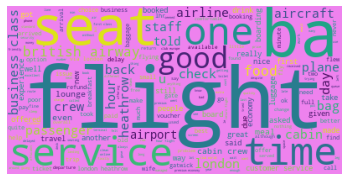

In [103]:
wordcloud = WordCloud(background_color='violet',max_font_size=100).generate(' '.join(df['Review']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


In [104]:
data['sentiment'].value_counts()

positive    671
negative    314
neutral      15
Name: sentiment, dtype: int64

In [105]:
import matplotlib.pyplot as plt

In [106]:
bars=df['sentiment'].value_counts().values
bars

array([671, 314,  15], dtype=int64)

<BarContainer object of 3 artists>

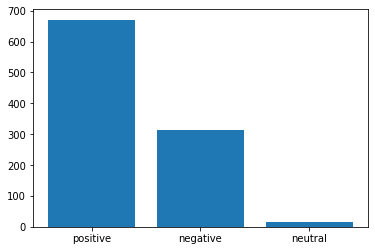

In [107]:
plt.bar(df['sentiment'].unique(),bars)

From the above analysis,Out of 1000 reviews, 67.1% are positive reviews and 32.9% are negative reviews and 15% of the people are neutral about there revies which are collected for the given website using web Scraping.

([<matplotlib.patches.Wedge at 0x1fbb69c0f10>,
 [Text(-0.5629173114515006, 0.945052432655572, 'positive'),
  Text(0.5177743806288017, -0.9705203196041086, 'negative'),
  Text(1.3485013368475807, -0.06359358867282117, 'neutral')],
 [Text(-0.307045806246273, 0.5154831450848575, '67.1%'),
  Text(0.28242238943389175, -0.5293747197840591, '31.4%'),
  Text(0.8490563972744025, -0.0400404076828874, '1.5%')])

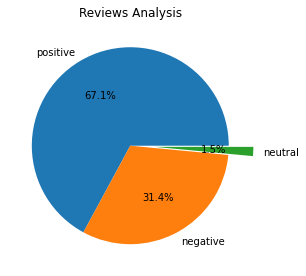

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))

plt.subplot(1,3,2)
plt.title("Reviews Analysis")
plt.pie(bars, labels =['positive','negative','neutral'], explode = (0, 0, 0.25), autopct='%1.1f%%', shadow=False)

In [109]:
df2=data

In [110]:
negative_reviews = (' '.join(df2['Review']))

In [111]:
negative_reviews

'excellent service ground board first class product might leading edge service around entire experience well worth cost ticket concorde room heathrow well managed great place relax prior trip flight slightly delayed heathrow arrived schedule johannesburg good lounge cape town time departure drink high quality sound dinner service breakfast reasonable arrival lounge good shower cold really excellent journey lounge overcrowded late afternoon plenty edible food easy boarding new club world suite great compared last travelled year ago food drink back previous standard choice individual wine rather bland blend course served individually cut glass china beef cheek really tasty surprisingly good soup crew excellent good choice movie breakfast good night sleep fruit etc first manage full english offered arrival time could want quite gulf standard overall ba seems eventually got business class back standard flight one worst ever life wanted pamper bought business class looking forward new exper

In [46]:
from nltk import word_tokenize
tokens = word_tokenize(negative_reviews)

In [48]:
tokens

['excellent',
 'service',
 'ground',
 'board',
 'first',
 'class',
 'product',
 'might',
 'leading',
 'edge',
 'service',
 'around',
 'entire',
 'experience',
 'well',
 'worth',
 'cost',
 'ticket',
 'concorde',
 'room',
 'heathrow',
 'well',
 'managed',
 'great',
 'place',
 'relax',
 'prior',
 'trip',
 'flight',
 'slightly',
 'delayed',
 'heathrow',
 'arrived',
 'schedule',
 'johannesburg',
 'good',
 'lounge',
 'cape',
 'town',
 'time',
 'departure',
 'drink',
 'high',
 'quality',
 'sound',
 'dinner',
 'service',
 'breakfast',
 'reasonable',
 'arrival',
 'lounge',
 'good',
 'shower',
 'cold',
 'really',
 'excellent',
 'journey',
 'lounge',
 'overcrowded',
 'late',
 'afternoon',
 'plenty',
 'edible',
 'food',
 'easy',
 'boarding',
 'new',
 'club',
 'world',
 'suite',
 'great',
 'compared',
 'last',
 'travelled',
 'year',
 'ago',
 'food',
 'drink',
 'back',
 'previous',
 'standard',
 'choice',
 'individual',
 'wine',
 'rather',
 'bland',
 'blend',
 'course',
 'served',
 'individually',
 

In [54]:
#word_tokenize(text)
tokens = word_tokenize(negative_reviews)
text = nltk.Text(tokens)

In [55]:
text

<Text: excellent service ground board first class product might...>

In [57]:
text.concordance('bad')

Displaying 25 of 94 matches:
ke found van lhr flight cancelled due bad weather vancouver receive email airpo
ort got nowhere near condition became bad taken advice would spared everyone ne
t food good service flew back economy bad either flight attendant friendly enth
w seat back entertainment screen seat bad felt squished locked plus side window
reen light board bolted plane feeling bad personally thank magic really hope ge
n would dreadful experience passenger bad enough someone mobile seems ditched s
essed british airway customer service bad need worked till today received refun
ustomer service british airway really bad reach call centre agent even waiting 
rable customer support flight alright bad customer service never fly ba worst a
lovely flight issue every time fly ba bad experience promise never fly another 
experience cost originally booked due bad rep advice multiple call company even
er earlier used ba good result really bad experience avoid using ba travel firs
oor lot spa

In [58]:
text.concordance('poor')

Displaying 25 of 118 matches:
 wife uncomfortable leg room general poor especially passenger keep seat recli
 snack offered meal sent couple hour poor chicken cube reminded dog food mashe
y kid snack green wrap spinach onion poor mix food ba service grunt crammed se
ry turkey cooked sprout cubed potato poor taste quality mousse desert great th
coffee tea service meal food quality poor pre landing snack ploughman lunch do
rightly panned awkwardness extremely poor design seating seat long stated ba w
avoid ba long haul possible due many poor review first ride ba day exception s
ting anyway got map screenshot lunch poor quality plenty nice white wine alcoh
holic drink made cabin crew pleasant poor grooming let skirt trouser suit long
ass seat similar economy electronics poor onboard outbound return flight offer
g third legroom overall cramped seat poor legroom awful ife screen meal medioc
ass day evening flight lhr iad check poor kiosk work well staff called boardin
beef underwhelming sal

In [62]:
text.concordance('dirty')

Displaying 25 of 29 matches:
furniture carpeting finish club worn dirty said food lounge pretty good quality
enver heathrow flight terrible plane dirty economy usually fly business premium
sen make big deal poor service delay dirty aircraft packed lounge cabin crew et
ovided people customer service tired dirty cramped aircraft flight year one man
told full choose room given terrible dirty cramped room several time throughout
pped purpose checked back seat front dirty tray moved hole right side tv screen
ba business lounge cramped tasteless dirty lounge took u min find two chair sea
ome extremely disappointing aircraft dirty drink stain side cabin remains chewi
 seriously considering flew business dirty old flew family business class seat 
ound boeing san jose airplane filthy dirty club class bad enough suffer awful d
class flown long time plane old worn dirty crumb food seat floor previous fligh
captain communicated well gripe seat dirty window also dirty buy food item avai
ed well gri

In [63]:
text.concordance('waste')

Displaying 21 of 21 matches:
wo seat comfy cabin clean sink taped waste working offered hand sanitiser inste
ful orange running matter hour total waste money paid premium economy aware beg
o refund stupidly accepted e voucher waste time flexibility despite fact ba mon
okay overall club europe worth money waste money prague london first time flown
n norwegian b premium cabin route ba waste money mexico city barcelona via lond
mpany even part ba fly ba club world waste money mahe stockholm via london chec
er beware say travelling club europe waste money food better economy food past 
paid premium business class realised waste money breakfast standard full englis
usiness class anyone premium economy waste money overnight flight going accepta
rather wait long queue told info end waste time energy money apology make hour 
um economy far premium felt complete waste faro heathrow flight good issue yet 
efinitely unforgettable wrong reason waste money airline get pay try compensate
vantage ful

In [67]:
text.concordance('worst')

Displaying 25 of 70 matches:
iness class back standard flight one worst ever life wanted pamper bought busin
policy state make claim day probably worst business class experience ever airli
e ife system good selection mediocre worst part flight cpt remote stand bussed 
ure missing baggage customer service worst ever experienced arrived back phoeni
write review honestly never fly help worst experience ever airline flew british
k earlier way better embarrassing ba worst experience ever outbound flight canc
n manchester british airway probably worst air company ever flown took hour unl
ht bad customer service never fly ba worst airline experience ever flew people 
take boarding time unfortunately ort worst boarding gate obviously beyond ba co
sing arrived jogging gate asthma far worst travelling experience ever experienc
 hour enjoyable experience amsterdam worst airport experienced ba say ticket fl
overcrowding delay cancellation make worst airline endure business lounge close
 trip fligh

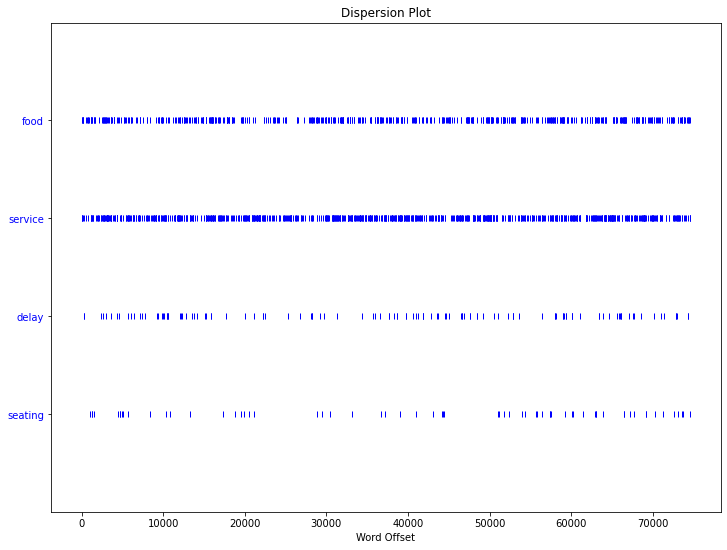

In [124]:
from nltk.draw.dispersion import dispersion_plot
plt.figure(figsize=(12, 9))
t=['food','service','delay','booking','']
#dispersion_plot(text, targets, ignore_case=True, title='Dispersion Plot')
nltk.draw.dispersion.dispersion_plot(text, targets, title='Dispersion Plot')

From the above plot we can say that Most of the people are not satisfied with Food and the customer service in the British airways and few of the people are worried about flight delay and seating in the flights. so fotr the customer satisfaction we should mainly focus on the aspects of Food,service,flight delay and seating in the British airways.

In [75]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\vamsi2001\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.


True

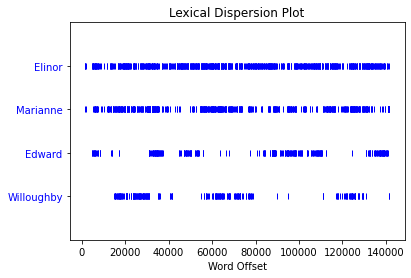

In [76]:
import matplotlib.pyplot as plt

from nltk.corpus import gutenberg

words = ["Elinor", "Marianne", "Edward", "Willoughby"]
dispersion_plot(gutenberg.words("austen-sense.txt"), words)
plt.show()